## 1. 데이터 로드하기

In [3]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [5]:
# 환경에 맞게 경로 수정
home_dir = os.getenv('HOME')+'/aiffel/gd_14_babi_memory_net'
file_to_save = home_dir + '/babi-tasks-v1-2.tar.gz'
path = get_file(file_to_save, origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
print(path)

11747328/11745123 [==============================] - 7s 1us/step
/home/ssac14/aiffel/gd_14_babi_memory_net/babi-tasks-v1-2.tar.gz


In [6]:
with tarfile.open(path) as tar:
    tar.extractall(home_dir)  # home_dir 아래에 압축해제
    tar.close()

In [7]:
# 환경에 맞게 경로 적절히 수정
DATA_DIR = home_dir + '/tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [8]:
# 훈련데이터에서 20개 문장 출력
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


<br><br><br><br>

## 2. 데이터 전처리

### 2-1. 기본 전처리

In [9]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [11]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [12]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [13]:
# 임의로 3879번째 스토리 출력
train_stories[3878]

['Daniel journeyed to the bathroom.',
 'Sandra moved to the office.',
 'John went to the kitchen.',
 'Sandra moved to the bathroom.',
 'Daniel moved to the hallway.',
 'Mary travelled to the kitchen.',
 'Daniel went to the kitchen.',
 'Daniel travelled to the bathroom.']

In [14]:
# 상위 5개 질문 출력
train_questions[:5]

['Where is Mary? ',
 'Where is Daniel? ',
 'Where is Daniel? ',
 'Where is Daniel? ',
 'Where is Sandra? ']

In [15]:
# 상위 5개 답변 출력
train_answers[:5]

['bathroom', 'hallway', 'hallway', 'office', 'bathroom']

In [17]:
# 토큰화
def tokenize(sent):
    return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] 

In [19]:
# 단어장을 생성하고, 단어에서 정수로, 정수에서 단어로 맵핑하는 딕셔너리(dictionary) 생성
# 스토리와 질문의 가장 긴 길이를 구하여 패딩에 적용
# 같은 스토리 내의 여러 문장들을 하나의 문장으로 통합
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [20]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [21]:
print(word2idx)

{'to': 1, 'the': 2, '.': 3, 'went': 4, 'Sandra': 5, 'John': 6, 'Daniel': 7, 'Mary': 8, 'travelled': 9, 'journeyed': 10, 'back': 11, 'bathroom': 12, 'garden': 13, 'hallway': 14, 'moved': 15, 'office': 16, 'kitchen': 17, 'bedroom': 18, 'Where': 19, 'is': 20, '?': 21}


In [22]:
# 실제 변수로 사용할 단어장의 크기는 패딩을 고려하여 +1을 해주어야함
vocab_size = len(word2idx) + 1

In [23]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 68
질문의 최대 길이 : 4


### 2-2. 패딩, 정수 인코딩, 벡터화

In [24]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [25]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [26]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)


<br><br><br><br>

## 3. 메모리 네트워크 구현

In [27]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [28]:
train_epochs = 120  # 에포크 횟수
batch_size = 32     # 배치 크기
embed_size = 50     # 임베딩 크기
lstm_size = 64      # LSTM의 크기
dropout_rate = 0.30 # 과적합 방지 기법인 드롭아웃 적용 비율

In [29]:
# 입력을 담아두는 변수 정의
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 68), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 4), dtype=float32)


![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-7-L-02.max-800x600.png)

In [30]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원


# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [31]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [33]:
# 구현된 인코더를 이용해 텍스트를 임베딩으로 변환
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m Tensor("sequential_3/Identity:0", shape=(None, 68, 50), dtype=float32) 

Input encoded c Tensor("sequential_1_1/Identity:0", shape=(None, 68, 4), dtype=float32) 

Question encoded Tensor("sequential_2_1/Identity:0", shape=(None, 4, 50), dtype=float32) 



**스토리 문장과 질문 문장의 매칭 유사도 계산 과정**
![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-7-L-03.max-800x600.png)

In [34]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/Identity:0", shape=(None, 68, 4), dtype=float32)


In [35]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/Identity:0", shape=(None, 4, 68), dtype=float32)


In [36]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/Identity:0", shape=(None, 4, 118), dtype=float32)


In [38]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 0.0741 - acc: 0.9762 - val_loss: 0.5257 - val_acc: 0.8700
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0760 - acc: 0.9746 - val_loss: 0.5293 - val_acc: 0.8690
Epoch 3/120
313/313 [==============================] - 1s 4ms/step - loss: 0.0706 - acc: 0.9756 - val_loss: 0.5810 - val_acc: 0.8630
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0708 - acc: 0.9791 - val_loss: 0.5026 - val_acc: 0.8750
Epoch 5/120
313/313 [==============================] - 1s 4ms/step - loss: 0.0606 - acc: 0.9790 - val_loss: 0.5185 - val_acc: 0.8770
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0618 - acc: 0.9796 - val_loss: 0.5399 - val_acc: 0.8730
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0597 - acc: 0.9822 - val_loss: 0.5259 - val_acc: 0.8690
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 4ms/step - loss: 0.0332 - acc: 0.9904 - val_loss: 0.5283 - val_acc: 0.8910
Epoch 63/120
313/313 [==============================] - 1s 4ms/step - loss: 0.0373 - acc: 0.9893 - val_loss: 0.5360 - val_acc: 0.8880
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0363 - acc: 0.9882 - val_loss: 0.5803 - val_acc: 0.8860
Epoch 65/120
313/313 [==============================] - 1s 4ms/step - loss: 0.0361 - acc: 0.9902 - val_loss: 0.5511 - val_acc: 0.8830
Epoch 66/120
313/313 [==============================] - 1s 4ms/step - loss: 0.0376 - acc: 0.9892 - val_loss: 0.5040 - val_acc: 0.8880
Epoch 67/120
313/313 [==============================] - 1s 4ms/step - loss: 0.0332 - acc: 0.9910 - val_loss: 0.5187 - val_acc: 0.8920
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0412 - acc: 0.9884 - val_loss: 0.5609 - val_acc: 0.8860
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [39]:
# 훈련 후 모델 저장
model_path = os.getenv('HOME')+'/aiffel/gd_14_babi_memory_net/model.h5'
model.save(model_path)

In [40]:
# 테스트 정확도 출력
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.5821 - acc: 0.8930

 테스트 정확도: 0.8930


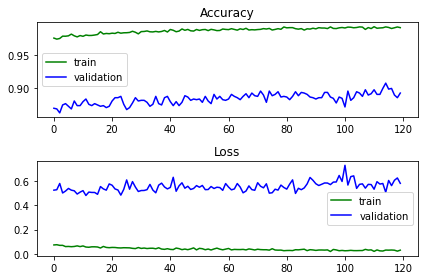

In [41]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [42]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
Where is John ?     : hallway  hallway
Where is Mary ?     : bathroom bathroom
Where is Sandra ?   : kitchen  kitchen
Where is Sandra ?   : hallway  hallway
Where is Sandra ?   : kitchen  kitchen
Where is Sandra ?   : hallway  hallway
Where is Sandra ?   : garden   garden
Where is Daniel ?   : hallway  hallway
Where is Sandra ?   : office   garden
Where is Daniel ?   : office   kitchen
Where is Mary ?     : kitchen  kitchen
Where is Mary ?     : garden   garden
Where is Daniel ?   : office   office
Where is Mary ?     : bedroom  bedroom
Where is Mary ?     : bedroom  bedroom
Where is John ?     : kitchen  kitchen
Where is John ?     : garden   garden
Where is John ?     : kitchen  kitchen
Where is Daniel ?   : office   kitchen
Where is John ?     : kitchen  kitchen
Where is Mary ?     : hallway  hallway
Where is John ?     : office   office
Where is John ?     : office   office
Where is Sandra ?   : hallway  hallw